In [2]:
%load_ext autoreload
%autoreload 2


# Building XGBoost model to predict pose angles

In [4]:
# IMPORTS

from ptai.ml_logic.data import generate_keypoints_for_xgboost, load_image_data
from ptai.movenet.movenet_main import angle_calc, plot_skeleton_on_image
from ptai.movenet.movenet_model import load_model_from_tfhub, run_movenet_inference

from flaml import AutoML
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

import xgboost as xgb


In [4]:
# Get current working directory
current_wd = os.getcwd()
current_wd


'/Users/mischadhar/code/ds-projects/pose-detection/q4-repo/pt-ai/notebooks'

In [5]:
# Combind cwd with path to cropped data to get full path of cropped images
cropped_img_path = os.path.join(current_wd,"../raw_data/cropped_data/")
cropped_img_path


'/Users/mischadhar/code/ds-projects/pose-detection/q4-repo/pt-ai/notebooks/../raw_data/cropped_data/'

In [6]:
# Check that the above path is valid
os.listdir(cropped_img_path)


['.DS_Store', 'squats', 'lunge_right', 'pushups', 'lunge_left']

In [7]:
# Generate list of keypoints for all cropped images and a corresponding list of what pose they are
keypoints_list, pose_list = generate_keypoints_for_xgboost(cropped_img_path)


100%|██████████| 4776/4776 [00:52<00:00, 90.89it/s]


In [8]:
len(keypoints_list), len(pose_list)


(29063, 29063)

In [9]:
keypoints_list[0]


array([[[[0.22291104, 0.50683916, 0.70918375],
         [0.20083743, 0.52334654, 0.57092524],
         [0.19948319, 0.4849938 , 0.7734792 ],
         [0.19391076, 0.53068554, 0.72944224],
         [0.19669734, 0.4464955 , 0.8546109 ],
         [0.26471007, 0.5800722 , 0.71116006],
         [0.28343493, 0.3934021 , 0.84901595],
         [0.38314056, 0.6457009 , 0.77978957],
         [0.44514686, 0.34535787, 0.70658517],
         [0.45654923, 0.6302372 , 0.71176285],
         [0.48167866, 0.4473812 , 0.69527286],
         [0.47510156, 0.5263932 , 0.7868876 ],
         [0.48206896, 0.42282218, 0.7966123 ],
         [0.6616962 , 0.5878023 , 0.6962302 ],
         [0.6737335 , 0.41392547, 0.7851135 ],
         [0.8059591 , 0.56413305, 0.7275264 ],
         [0.8189659 , 0.39408323, 0.7624229 ]]]], dtype=float32)

In [10]:
# angle_calc(keypoints_list[0])

keypoints_dict_list = [angle_calc(keypoint) for keypoint in keypoints_list]


In [11]:
set(pose_list)


{'lunge_left', 'lunge_right', 'pushups', 'squats'}

In [12]:
X = pd.DataFrame(keypoints_dict_list)

poses_series = pd.Series(pose_list)
# poses_series = poses_series.map({'squats':0,'lunge_left':1,'lunge_right':2,'pushups':3})

y = np.array(poses_series)

X.shape, y.shape


((29063, 14), (29063,))

In [36]:
full_data = pd.concat((X, poses_series), axis=1).rename(columns={0:'target'})
full_data.to_csv('../raw_data/full_keypoints.csv')


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((23250, 14), (5813, 14), (23250,), (5813,))

In [14]:
print(np.unique(y_train, return_counts=True)[1]/len(y_train))
print(np.unique(y_test, return_counts=True)[1]/len(y_test))


[0.1643871  0.15965591 0.34864516 0.32731183]
[0.16411491 0.16377086 0.35971099 0.31240323]


In [15]:
np.unique(y_train, return_counts=True)


(array(['lunge_left', 'lunge_right', 'pushups', 'squats'], dtype=object),
 array([3822, 3712, 8106, 7610]))

In [16]:
class LabelEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder = LabelEncoder()

    def fit(self, X, y=None):
        # Fit the label encoder to y, not X
        self.encoder.fit(y)
        return self

    def transform(self, X, y=None):
        # Transform y, not X
        return self.encoder.transform(y)

    def fit_transform(self, X, y=None):
        # Fit and transform y
        return self.fit(X, y).transform(y)

    def inverse_transform(self, y, copy=None):
        # Inverse transform y
        return self.encoder.inverse_transform(y)


In [60]:
xgb_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
    ])

xgb_pipeline


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='mlogloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [61]:
print(xgb_pipeline.get_params().keys())


dict_keys(['memory', 'steps', 'verbose', 'scaler', 'xgb', 'scaler__clip', 'scaler__copy', 'scaler__feature_range', 'xgb__objective', 'xgb__base_score', 'xgb__booster', 'xgb__callbacks', 'xgb__colsample_bylevel', 'xgb__colsample_bynode', 'xgb__colsample_bytree', 'xgb__device', 'xgb__early_stopping_rounds', 'xgb__enable_categorical', 'xgb__eval_metric', 'xgb__feature_types', 'xgb__gamma', 'xgb__grow_policy', 'xgb__importance_type', 'xgb__interaction_constraints', 'xgb__learning_rate', 'xgb__max_bin', 'xgb__max_cat_threshold', 'xgb__max_cat_to_onehot', 'xgb__max_delta_step', 'xgb__max_depth', 'xgb__max_leaves', 'xgb__min_child_weight', 'xgb__missing', 'xgb__monotone_constraints', 'xgb__multi_strategy', 'xgb__n_estimators', 'xgb__n_jobs', 'xgb__num_parallel_tree', 'xgb__random_state', 'xgb__reg_alpha', 'xgb__reg_lambda', 'xgb__sampling_method', 'xgb__scale_pos_weight', 'xgb__subsample', 'xgb__tree_method', 'xgb__validate_parameters', 'xgb__verbosity', 'xgb__use_label_encoder'])


In [105]:
y_encoder = LabelEncoder()

y_train_encoded = y_encoder.fit_transform(y_train)
y_train_encoded


array([2, 2, 3, ..., 3, 2, 2])

In [108]:
# param_grid = {
#     'xgb__n_estimators': [400,500,600,800],
#     'xgb__learning_rate': [0.01,0.02,0.05,0.1],
#     'xgb__max_depth': [5,6,7,8,9,10],
#     'xgb__subsample': [0.5,0.75]
# }

# grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=5, scoring='accuracy',verbose=2)  # 5-fold cross-validation

# # Fit GridSearchCV
# grid_search.fit(X_train, y_train_encoded)


In [ ]:

# # Best parameters and estimator
# best_params = grid_search.best_params_
# best_estimator = grid_search.best_estimator_

# y_pred = best_estimator.predict(X_test)


In [112]:
automl = AutoML()
settings = {
    "time_budget": 1200,
    "metric": 'accuracy',
    "task": 'classification',
    "early_stop": 'auto',
    "log_file_name": 'xgboost.log',
    "estimator_list": ['xgboost']
}


In [113]:
automl.fit(X_train=X_train, y_train=y_train, **settings)


[flaml.automl.logger: 12-05 17:24:07] {1679} INFO - task = classification
[flaml.automl.logger: 12-05 17:24:07] {1690} INFO - Evaluation method: cv
[flaml.automl.logger: 12-05 17:24:07] {1788} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 12-05 17:24:07] {1900} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl.logger: 12-05 17:24:07] {2218} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 12-05 17:24:08] {2344} INFO - Estimated sufficient time budget=1847s. Estimated necessary time budget=2s.
[flaml.automl.logger: 12-05 17:24:08] {2391} INFO -  at 0.2s,	estimator xgboost's best error=0.1886,	best estimator xgboost's best error=0.1886
[flaml.automl.logger: 12-05 17:24:08] {2218} INFO - iteration 1, current learner xgboost
[flaml.automl.logger: 12-05 17:24:08] {2391} INFO -  at 0.4s,	estimator xgboost's best error=0.1812,	best estimator xgboost's best error=0.1812
[flaml.automl.logger: 12-05 17:24:08] {2218} INFO - iteration 2, curren

In [121]:
print('Best ML model:', automl.model)
print('Best hyperparameters:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1 - automl.best_loss))

xgb_classifier = automl.model


Best ML model: <flaml.automl.model.XGBoostSklearnEstimator object at 0x2dabdefe0>
Best hyperparameters: {'n_estimators': 870, 'max_leaves': 762, 'min_child_weight': 0.0351256190051662, 'learning_rate': 0.05866336139380266, 'subsample': 0.7599921990176691, 'colsample_bylevel': 0.5336448042186835, 'colsample_bytree': 0.997766789401337, 'reg_alpha': 0.14690091532273586, 'reg_lambda': 0.004052951929486785}
Best accuracy on validation data: 0.9605


In [122]:

# Predict on the test data
y_pred = xgb_classifier.predict(X_test)
y_pred


array([2, 2, 2, ..., 1, 3, 0])

In [123]:
y_test_encoded = y_encoder.transform(y_test)
# y_pred_encoded = y_encoder.transform(y_pred)
accuracy_score(y_test_encoded, y_pred_encoded)


0.9588852571821779

## VALIDATE ON REAL IMAGES???

In [5]:
movenet = load_model_from_tfhub()


In [7]:
test_images = os.listdir("../raw_data/test_images/")

test_images =[image for image in test_images if "IMG_88" not in image]

test_images


['IMG_1196.jpg',
 'IMG_1206.jpg',
 'IMG_1205.jpg',
 'IMG_1199.jpg',
 'pushup_test.jpg',
 'squat_test.jpeg']

In [8]:
test_keypoints = []
test_image_data = []

for image in test_images:

    test_image_path = os.path.join("../raw_data/test_images/", image)

    image_data = load_image_data(test_image_path)

    test_image_data.append(image_data[0])
    keypoints_tmp = run_movenet_inference(model=movenet,image=image_data)
    test_keypoints.append(keypoints_tmp)


2023-12-06 10:14:14.310117: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1280 1280 3
[1200. 1200.]


ValueError: cannot reshape array of size 4320000 into shape (3200,2400,3)

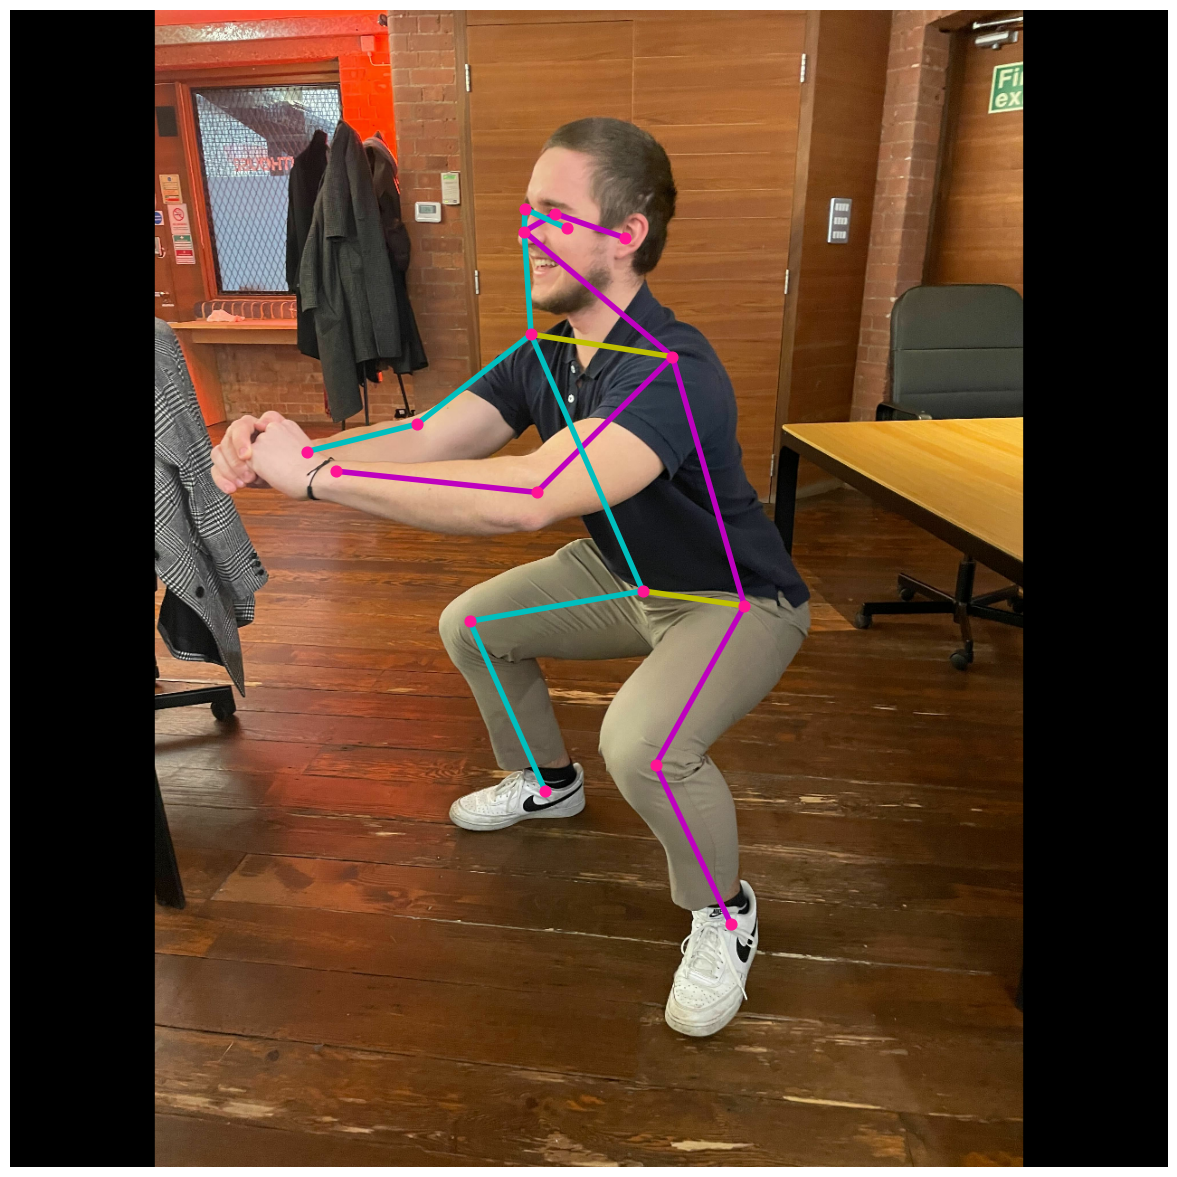

In [9]:
plot_skeleton_on_image(os.path.join("../raw_data/test_images/", test_images[0]), test_keypoints[0])


In [10]:
test_keypoint_dicts = [angle_calc(keypoint) for keypoint in test_keypoints]


In [11]:
X_news = pd.DataFrame(test_keypoint_dicts)


In [12]:
X_pushup = pd.DataFrame(test_keypoint_dicts[1], index=[0])
X_pushup


,left_elbow_a,right_elbow_a,left_shoulder_b,left_shoulder_a,right_shoulder_b,right_shoulder_a,left_hip_a,left_hip_b,left_hip_c,right_hip_a,right_hip_b,right_hip_c,left_knee_a,right_knee_a
0,149.95275,177.974147,52.138058,95.29691,67.278299,76.278296,91.731206,148.182675,120.086118,96.693588,138.915557,124.390876,69.810561,103.545743


In [13]:
X_squat = pd.DataFrame(test_keypoint_dicts[0], index=[0])
X_squat


,left_elbow_a,right_elbow_a,left_shoulder_b,left_shoulder_a,right_shoulder_b,right_shoulder_a,left_hip_a,left_hip_b,left_hip_c,right_hip_a,right_hip_b,right_hip_c,left_knee_a,right_knee_a
0,128.978632,155.77188,61.128875,115.112361,75.316667,57.473125,65.505196,134.662767,69.157571,121.909304,161.694374,76.396315,125.459934,75.979721


In [14]:
# pushup_pred = xgb_classifier.predict(X_pushup)

# y_encoder.inverse_transform(pushup_pred)

# squat_pred = xgb_classifier.predict(X_squat)

# y_encoder.inverse_transform(squat_pred)


In [1]:
import pickle


In [3]:
with open('../raw_data/models/best_automl_model.pkl', 'rb') as f:
    loaded_automl = pickle.load(f)


In [20]:
print(test_images)


['IMG_1196.jpg', 'IMG_1206.jpg', 'IMG_1205.jpg', 'IMG_1199.jpg', 'pushup_test.jpg', 'squat_test.jpeg']


In [17]:
# 'lunge_left': 0, 'lunge_right': 1, 'pushups': 2, 'squats': 3

loaded_automl.predict(X_news)


array([3, 1, 2, 2, 2, 1])

In [24]:
def train_posedetect_model(X_train, y_train, settings_dict):

    """Function to train model using AutoML (FLAML)
    Be sure to specify in settings at least the following parameters:
    1) 'time_budget': <seconds, int>
    2) 'metric': <str>
    3) 'task': <classification, str>
    4) 'early_stop': <auto, str>
    5) 'estimator_list': <model type, str>

    Returns the fitted model with the best parameters as determined by AutoML
    """

    automl = AutoML()

    automl.fit(X_train=X_train, y_train=y_train, **settings_dict)

    print('Best ML model:', automl.model)
    print('Best hyperparameters:', automl.best_config)
    print('Best accuracy on validation data: {0:.4g}'.format(1 - automl.best_loss))

    best_model = automl.model

    return best_model

def posedetect_preproc(image: np.array, movenet_model) -> dict:

    """This function preprocesses input for pose detection inference by:
    1) Take in any image and run skeleton detection with Movenet Single Pose Lightning
    2) Calculate the angles of the skeleton
    3) Return these angles as a dictionary"""

    keypoints = run_movenet_inference(model=movenet_model,image=image)

    keypoint_angles = angle_calc(keypoints)

    return keypoint_angles

def save_posedetect_model(model_path):

    """Save model to specified model path"""

    with open(model_path, 'wb') as f:
        pickle.dump(xgb_classifier, f)

    print(f"Model saved to: {model_path}")

def load_posedetect_model(model_path):

    """"Load posedetection model from a specified path"""

    with open(model_path, 'rb') as f:
        loaded_model = pickle.load(f)

    print(f"Loaded model from: {model_path}")

    return loaded_model


def posedetect_inference(keypoints: dict, posedetect_model, encoder, encoded = True):

    """Function to run inference on calculated angles of 'skeleteon' provided by Movenet
    Multiclass classifier XGBoost - returns one of three classes,
    'lunge_left': 0, 'lunge_right': 1, 'pushups': 2, 'squats': 3

    Can return classes labels as encoded or as strings
    """

    prediction = posedetect_model.predict(keypoints)

    if encoded == False:

        prediction = encoder.inverse_transform(prediction)

    return prediction


In [22]:
test_pushup = load_image_data('../raw_data/test_images/pushup_test.jpg')
test_squat = load_image_data('../raw_data/test_images/squat_test.jpeg')


In [26]:
y_encoder = None


In [28]:
news_preds = [posedetect_preproc(pred, movenet) for pred in [test_pushup, test_squat]]
news_preds = pd.DataFrame(news_preds)

news_preds

posedetect_inference(news_preds, loaded_automl, y_encoder)


array([2, 1])